**SECTION OBJECTIVES**
* Preparing hosehold dataset for **Binary Classification**
* Creating a **Logistic Regression** model to predict severe damage
* Explaining model predictiions using **Odds Ratio**
* Interrogating important features based on caste (a piece of demographic information)

**ML WORKFLOW**
* Preparing Data
    * Importing
    * Exploring: Grouping Categorical Feature
    * Splitting
* Building Model
    * Baselining
    * Iterating
    * Evaluating
* Communicating Results
    * Odds Ratios
    * Investigating apparent role of caste in building damage(?)

In [1]:
# Importing necessary libraries
import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

warnings.simplefilter(action = 'ignore', category = FutureWarning)

# 1. Preparing Data
### Inspecting Data in SQL
* 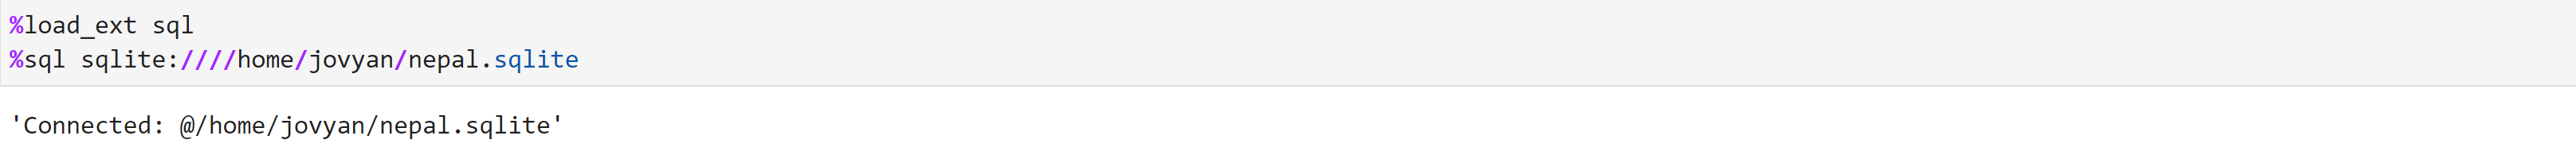

### Household_demographics Table
* Selecting all columns from the `household_demographics` table, and limiting results to first 5 rows
* 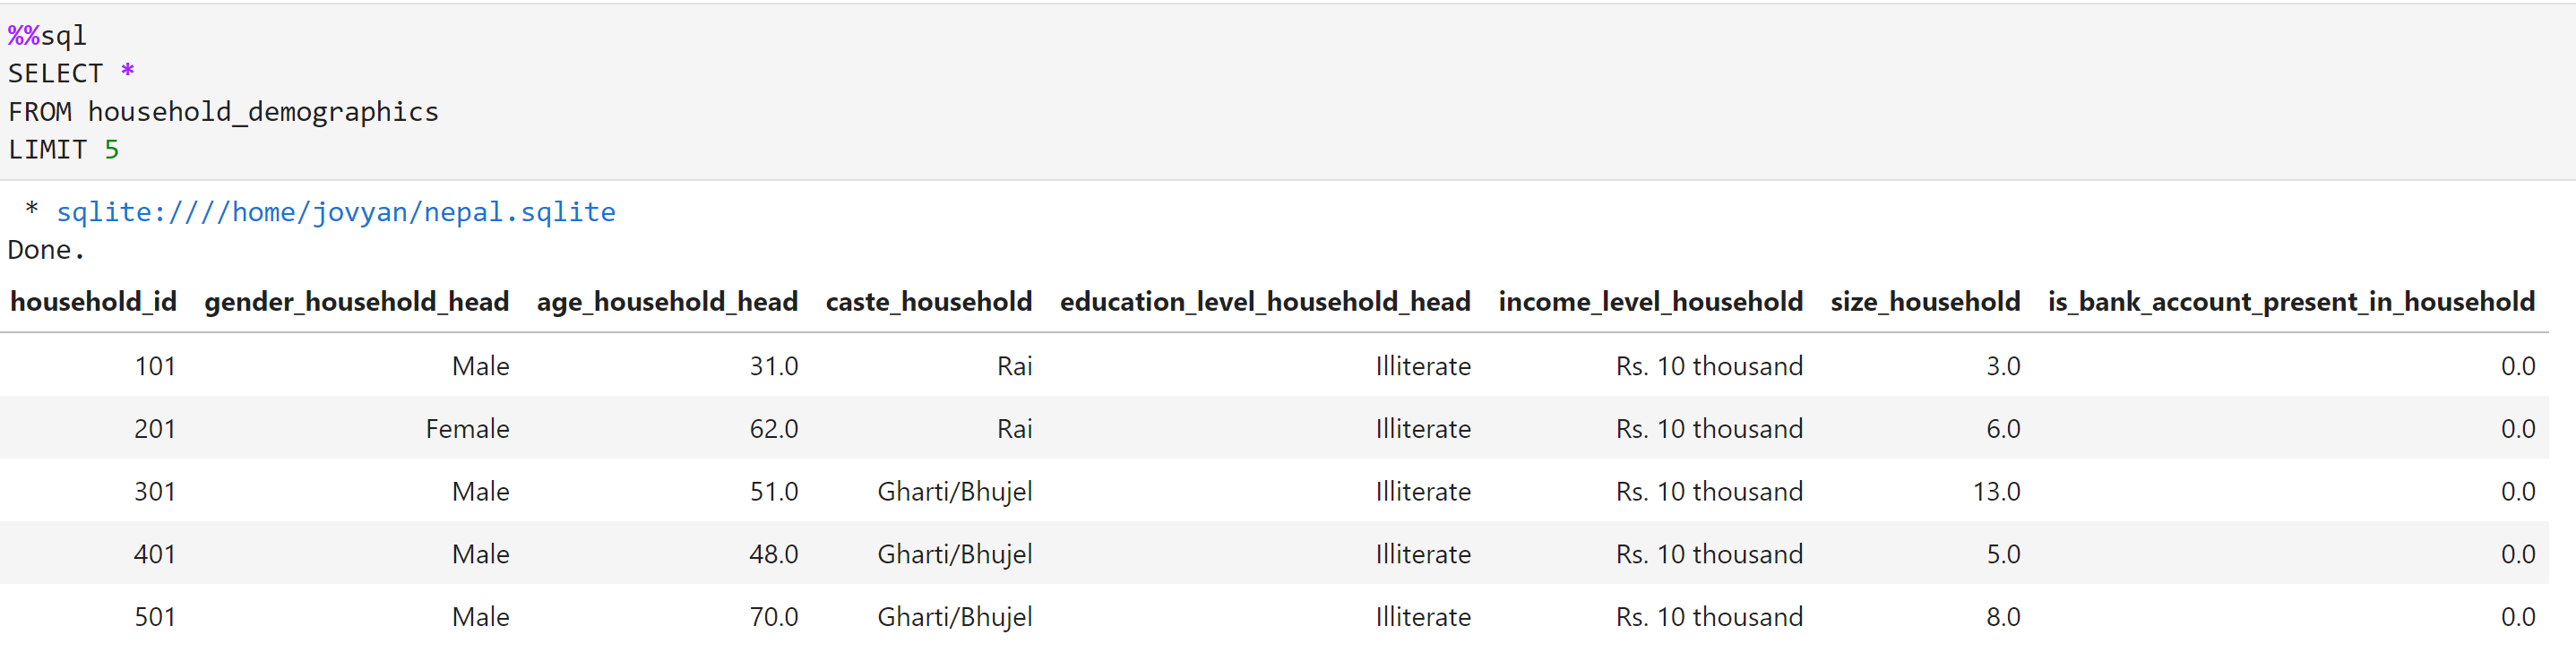

### Counting observations in `household_demographics` table
* 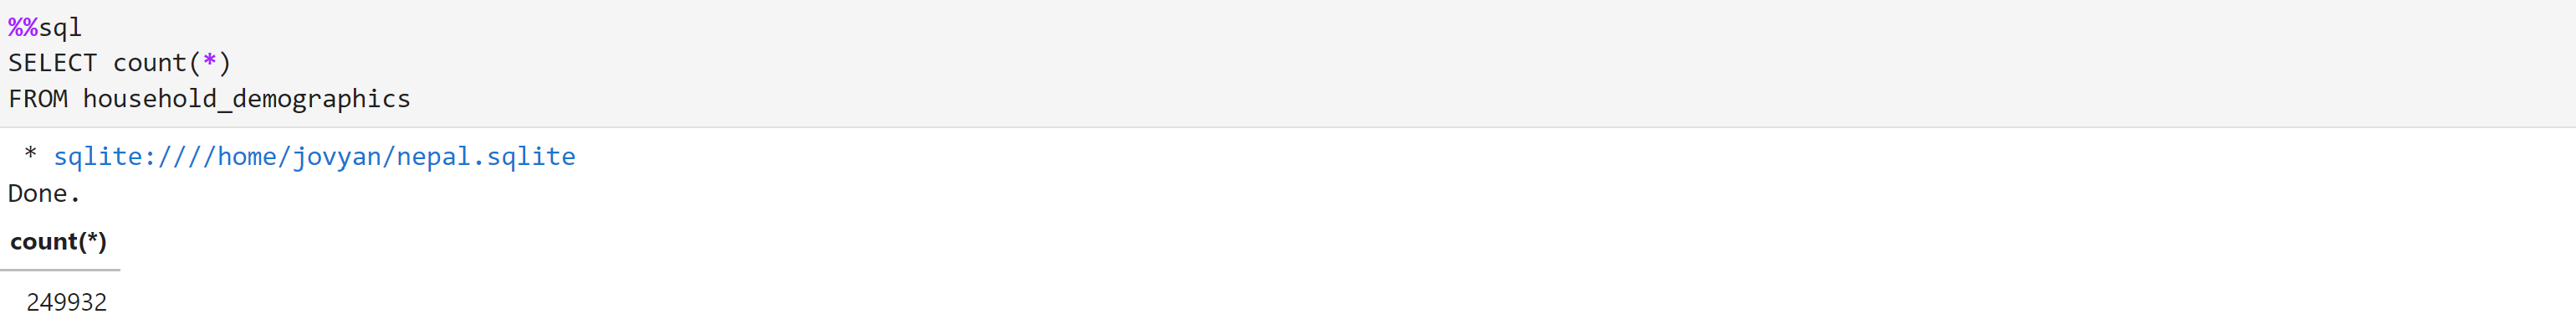

### Inspecting `id_map` table to find common columns with `household_demographics` for Joining these tables
* 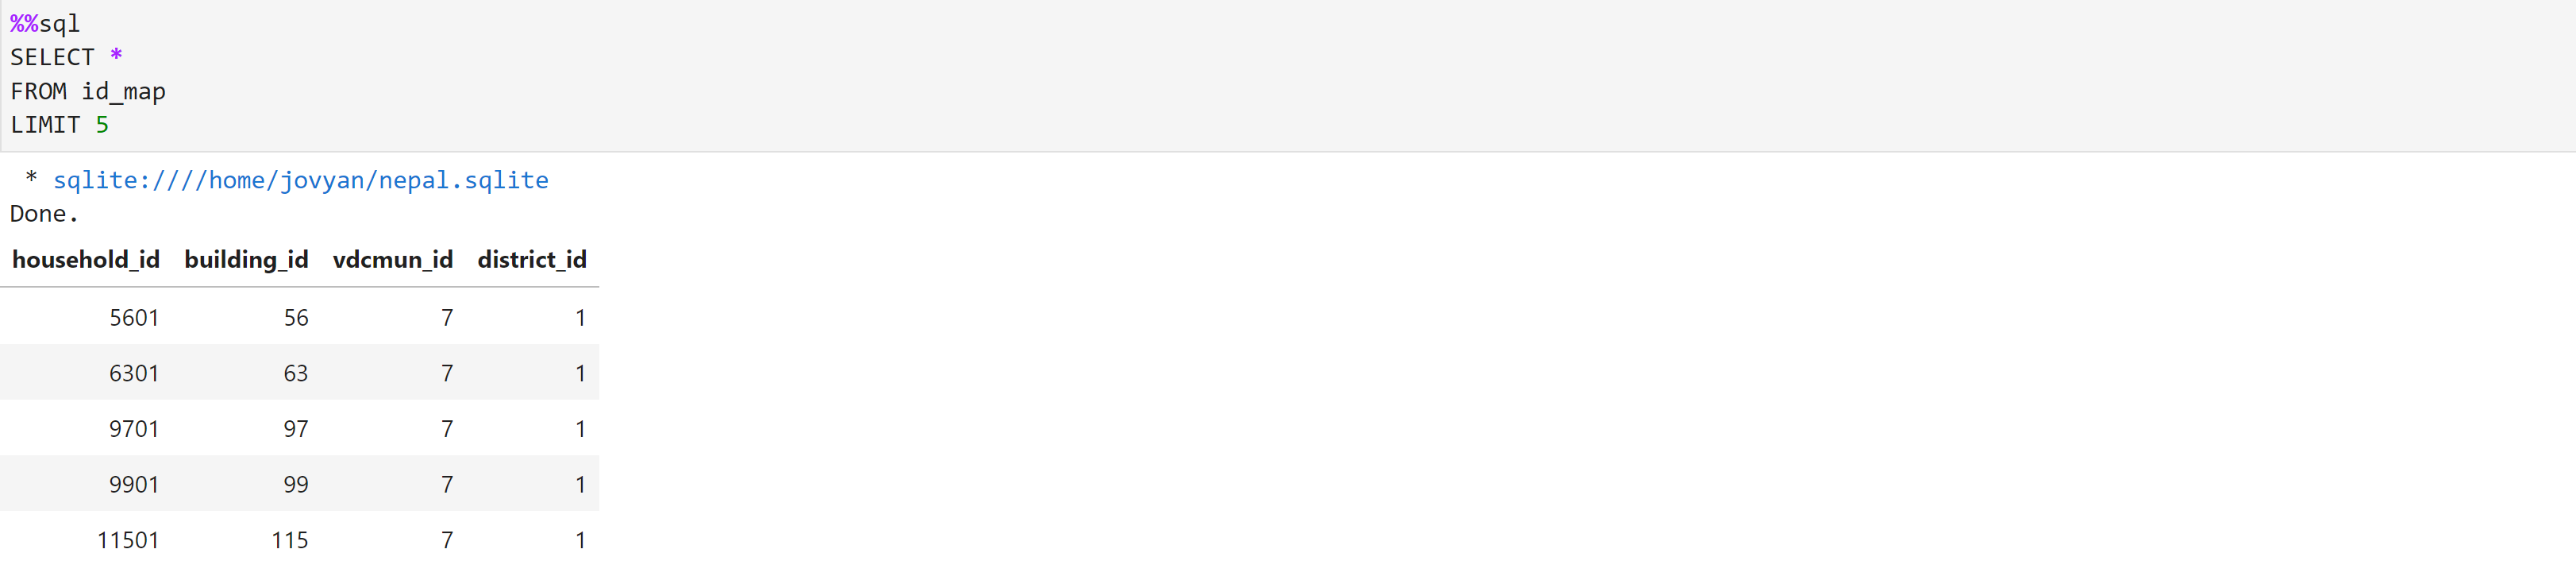
* It turns out that column `household_id` is common in both tables and could be used to join these tables

### Joining Four Tables
* Selecting all columns from `household_demographics`, all from `building_structure`, `vdcmun_id` (municipality id) from `id_map`, `damage_grade` from `building_damage` for `district_id` 4
* JOIN by default is a left Join
* 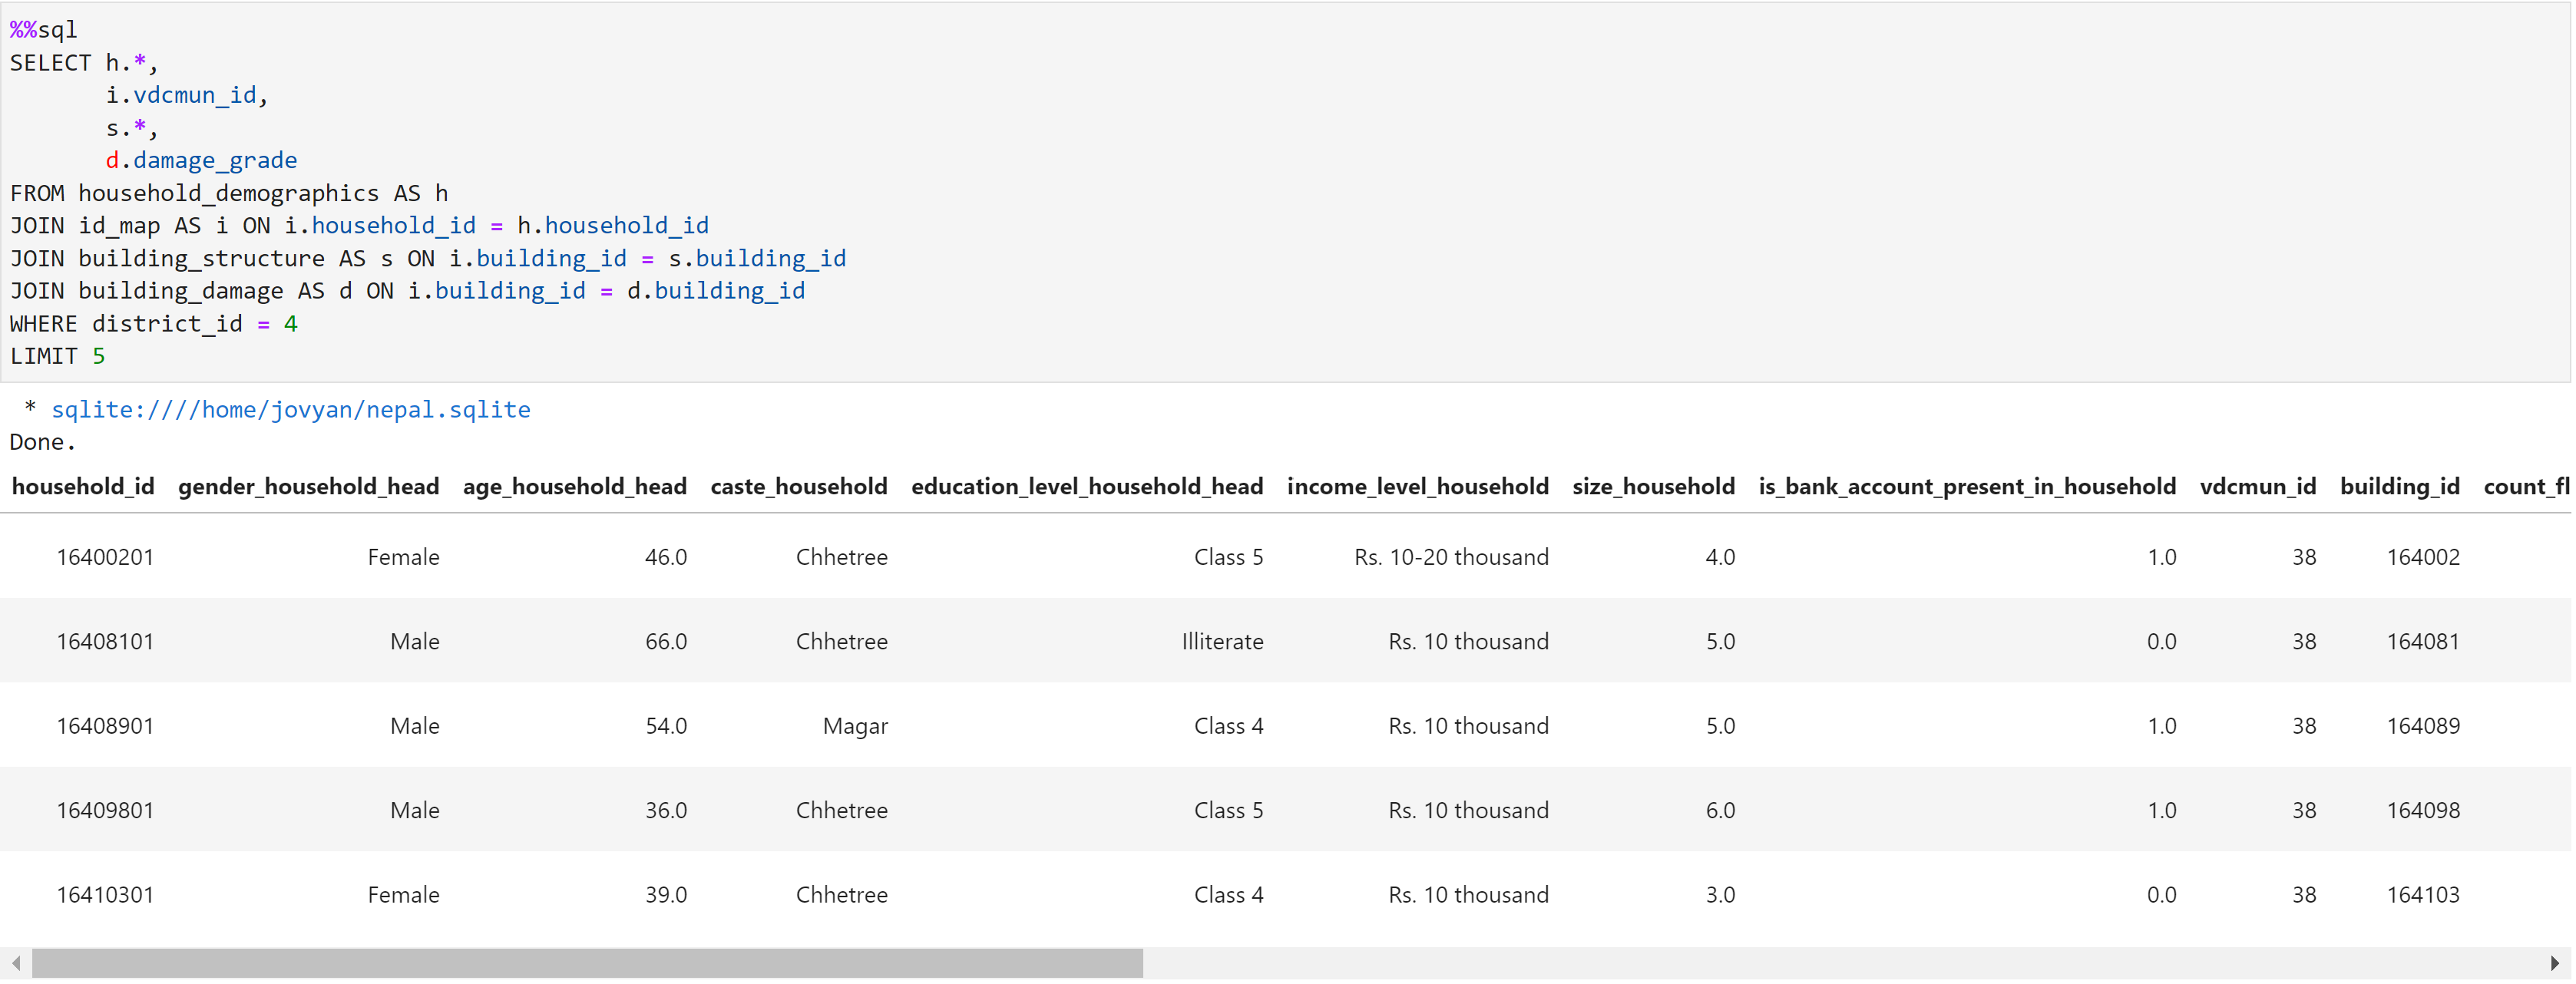

## 1.1 Importing Data
### Wrangle Function
* 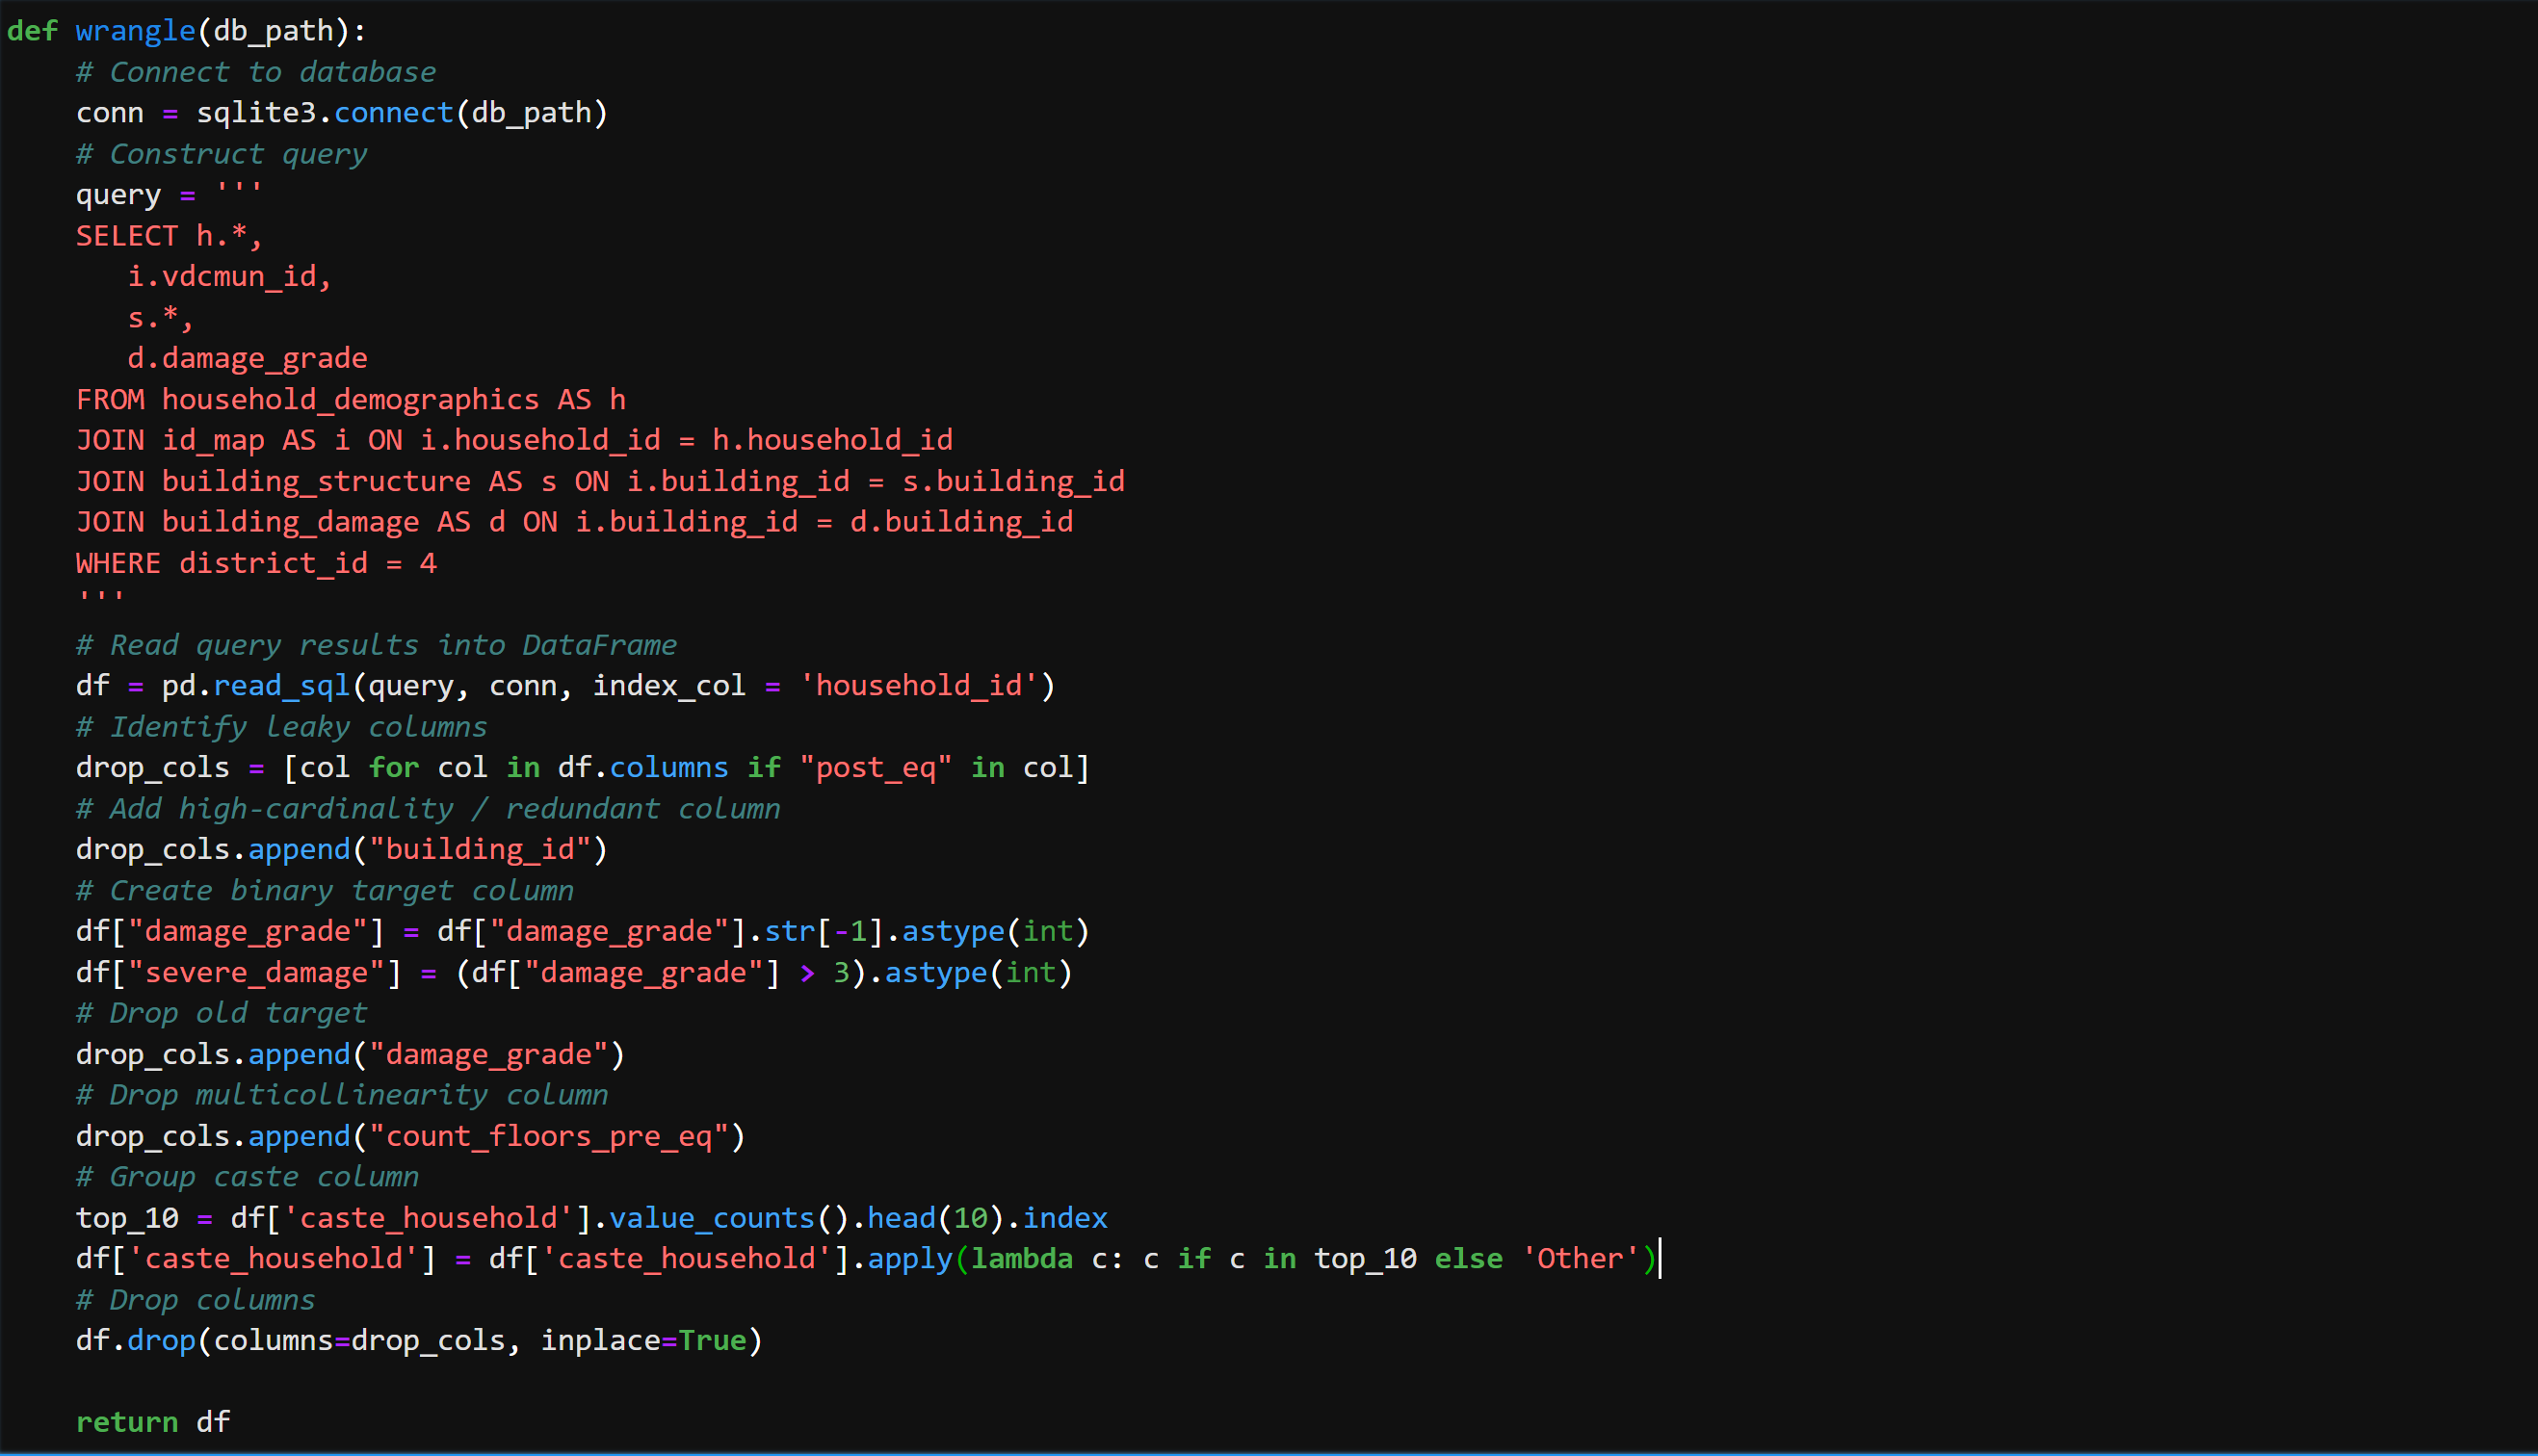

In [2]:
# Importing data from saved csv file
df = pd.read_csv('nepal-demographic-data.csv', index_col = 'household_id')
df.head()

,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,vdcmun_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
household_id,,,,,,,,,,,,,,,,,,,,
16400201,Female,46.0,Chhetree,Class 5,Rs. 10-20 thousand,4.0,1.0,38,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
16408101,Male,66.0,Chhetree,Illiterate,Rs. 10 thousand,5.0,0.0,38,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
16408901,Male,54.0,Magar,Class 4,Rs. 10 thousand,5.0,1.0,38,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
16409801,Male,36.0,Chhetree,Class 5,Rs. 10 thousand,6.0,1.0,38,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
16410301,Female,39.0,Chhetree,Class 4,Rs. 10 thousand,3.0,0.0,38,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


## 1.2 Exploring Data
### High-Cardinality Features
* Combining the `select_dtypes` and `nunique` methods to check for any high- or low-cardinality categorical features in the dataset

In [3]:
df.select_dtypes('object').nunique()

gender_household_head              2
caste_household                   63
education_level_household_head    19
income_level_household             5
land_surface_condition             3
foundation_type                    5
roof_type                          3
ground_floor_type                  5
other_floor_type                   4
position                           4
plan_configuration                10
superstructure                    11
dtype: int64

* `education_level_household_head` appears borderline high-cardinal. It is a matter of choice whether to keep it or drop this column
* `caste_household` needs further investigation

### Grouping Categorical Features
* Modifying `caste_household` to select only the 10 largest caste groups, and labeling the rest as `Other`

In [4]:
# Checking number of unique entries in the caste column
df['caste_household'].nunique()

63

In [5]:
# Checking number of entries for top 10 most frequent castes
df['caste_household'].value_counts().head(10)

Gurung          15119
Brahman-Hill    13043
Chhetree         8766
Magar            8180
Sarki            6052
Newar            5906
Kami             3565
Tamang           2396
Kumal            2271
Damai/Dholi      1977
Name: caste_household, dtype: int64

In [6]:
# Checking number of entries for 10 least frequent castes
df['caste_household'].value_counts().tail(10)

Rajbansi         2
Thami            2
Kanu             2
Kalwar           1
Satar/Santhal    1
Dhimal           1
Kayastha         1
Byasi/Sauka      1
Hyolmo           1
Kalar            1
Name: caste_household, dtype: int64

* It can be seen that several caste groups have only singular or double entries. They can be aggregated together to reduce cardinality in `caste_household` categorical feature
* Assigning `top_10` to 10 most frequently represented castes and grouping the rest as `Others`

In [7]:
top_10 = df['caste_household'].value_counts().head(10).index
top_10

Index(['Gurung', 'Brahman-Hill', 'Chhetree', 'Magar', 'Sarki', 'Newar', 'Kami',
       'Tamang', 'Kumal', 'Damai/Dholi'],
      dtype='object')

In [8]:
# Grouping the rest of castes together as `Other` using a Lambda function
df['caste_household'] = df['caste_household'].apply(lambda c: c if c in top_10 else 'Other')

In [10]:
# Checking the modified number of castes in `caste_household`
df.select_dtypes('object').nunique()

gender_household_head              2
caste_household                   11
education_level_household_head    19
income_level_household             5
land_surface_condition             3
foundation_type                    5
roof_type                          3
ground_floor_type                  5
other_floor_type                   4
position                           4
plan_configuration                10
superstructure                    11
dtype: int64

## 1.3 Splitting Data
### Vertical Split
* It is important to note that 'vdcmun_id' is a high-cardinality feature but since it is encoded as an integer, it did not show up.
* It must be removed from Feature Matrix while modeling

In [11]:
target = 'severe_damage'
X = df.drop(columns = [target, 'vdcmun_id'])
y = df[target]

### Horizontal Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (60706, 18)
y_train shape: (60706,)
X_test shape: (15177, 18)
y_test shape: (15177,)


# 2. Building Model
## 2.1 Baselining
* Calculating Baseline Accuracy Score for model

In [13]:
acc_baseline = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy:', round(acc_baseline, 2))

Baseline Accuracy: 0.63


## 2.2 Iterating

In [17]:
# Building model
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names = True), # Encoding categorical features
    LogisticRegression(max_iter = 2000) # Setting max_iter to 2000 to avoid Convergence Warning
)
# Fitting model to training data
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender_household_head', 'caste_household',
                                     'education_level_household_head',
                                     'income_level_household',
                                     'land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=2000))])

## 2.3 Evaluating Model
* Calculating Test and Training Accuracy Scores for the Model

In [21]:
acc_train = accuracy_score(y_train, model_lr.predict(X_train))
acc_test = model_lr.score(X_test, y_test)

print("LR Training Accuracy:", round(acc_train, 2))
print("LR Validation Accuracy:", round(acc_test, 2))

LR Training Accuracy: 0.72
LR Validation Accuracy: 0.72


# 3. Communicating Results
### Odds Ratio DataFrame

In [23]:
features = model_lr.named_steps['onehotencoder'].get_feature_names()
importances = model_lr.named_steps['logisticregression'].coef_[0]
feat_imp = pd.Series(np.exp(importances), index = features).sort_values()
feat_imp.head()

superstructure_Brick, cement mortar    0.305389
foundation_type_RC                     0.339423
roof_type_RCC/RB/RBC                   0.404451
caste_household_Kumal                  0.530611
ground_floor_type_RC                   0.539860
dtype: float64

### Odds Ratio Bar Chart
* Plotting features to see their impact on `severe_damge`

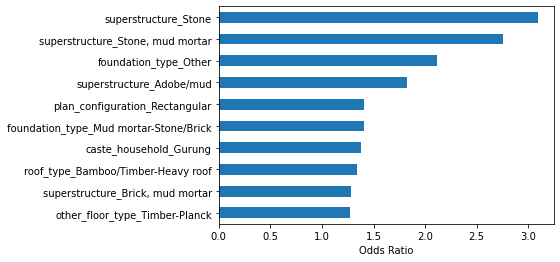

In [24]:
# Plotting 10 biggest Odds Ratios
feat_imp.tail(10).plot(kind = 'barh')
plt.xlabel('Odds Ratio');

* **It is peculiar that the model believes that if the caste of household is Gurung, then that building is almost 30% more likely to suffer severe damage**
* Although no conclusions must be drawn as of yet

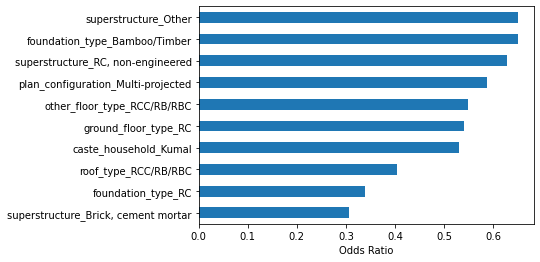

In [25]:
# Plotting 10 smallest Odds Ratios
feat_imp.head(10).plot(kind = 'barh')
plt.xlabel('Odds Ratio');

* **Again it appears that Kumal caste households are about 45% less likely to live in a building which suffers severe damage**
* But it does not make logical sense that people living inside a building impact the building's behaviour in an earthquake event
* Further investigation is needed to uncover what is really going on

### Exploring Further
#### Household Damage by Municipality

In [27]:
# Checking the proportion of severely damaged buildings by municipality and exporting to dataframe
damage_by_vdcmun = (
    df.groupby('vdcmun_id')['severe_damage'].mean().sort_values(ascending = False)
).to_frame()
damage_by_vdcmun

,severe_damage
vdcmun_id,
31,0.930199
32,0.851117
35,0.827145
30,0.824201
33,0.782464
34,0.666979
39,0.572344
40,0.512444
38,0.506425


#### Plotting Damage by Municipality

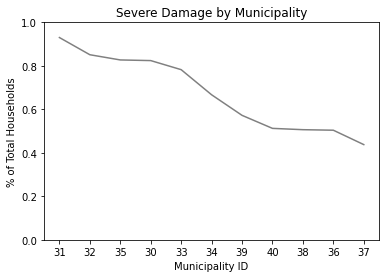

In [34]:
# Plotting line for municipality damage
plt.plot(damage_by_vdcmun.values, color = 'grey')
plt.xticks(range(len(damage_by_vdcmun)), labels = damage_by_vdcmun.index)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by Municipality");

#### Municipality Damage by Household Caste (Gurung, Kumal)

In [39]:
# Calculating proportion of Gurung households in each municipality
damage_by_vdcmun['Gurung'] = (
    df[df['caste_household'] == 'Gurung'].groupby('vdcmun_id')['severe_damage'].count()
    / df.groupby('vdcmun_id')['severe_damage'].count()
)
damage_by_vdcmun

,severe_damage,Gurung
vdcmun_id,,
31,0.930199,0.326937
32,0.851117,0.387849
35,0.827145,0.826889
30,0.824201,0.338152
33,0.782464,0.011943
34,0.666979,0.385084
39,0.572344,0.097971
40,0.512444,0.246727
38,0.506425,0.049023


In [41]:
# Calculating proportion of Kumal households in each municipality
damage_by_vdcmun['Kumal'] = (
    df[df['caste_household'] == 'Kumal'].groupby('vdcmun_id')['severe_damage'].count()
    / df.groupby('vdcmun_id')['severe_damage'].count()
).fillna(0)
damage_by_vdcmun

,severe_damage,Gurung,Kumal
vdcmun_id,,,
31,0.930199,0.326937,0.000000
32,0.851117,0.387849,0.000000
35,0.827145,0.826889,0.000000
30,0.824201,0.338152,0.000000
33,0.782464,0.011943,0.029478
34,0.666979,0.385084,0.000000
39,0.572344,0.097971,0.000267
40,0.512444,0.246727,0.036973
38,0.506425,0.049023,0.100686


* It can be observed that the most severely damaged municipalities had a large Gurung population
* In the least damaged municipalities the Gurung population is much smaller
* So it turns out that it is the municipality which is a determining factor instead of caste when it comes to severity of damage

### Weapons of Math Destruction

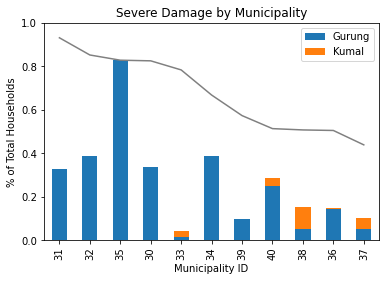

In [45]:
# Plotting lines for municipality damage wrt to Gurung and Kumal proportions
damage_by_vdcmun.drop(columns = 'severe_damage').plot(kind = 'bar', stacked = True)

plt.plot(damage_by_vdcmun['severe_damage'].values, color = 'grey')
plt.xticks(range(len(damage_by_vdcmun)), labels = damage_by_vdcmun.index)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by Municipality");

* A model trained on biased data would end up perpetuating social problems or systems of social injustice
* This is an important reminder to be cognizant of how the model works in real world